In [ ]:
pip install structure-tensor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for structure-tensor: filename=structure_tensor-0.2.0-py3-none-any.whl size=15924 sha256=1de95e4963190e2e646167712b412723d0ce3817c3fba50157b815bb4858496b
  Stored in directory: /root/.cache/pip/wheels/91/20/c3/7f70390148b5bd4ca9efcdd82ba1c678e7d26194a1c4d9401d
Successfully built structure-tensor


In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import random
import skimage.io
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import numpy as np
import os
from torch.utils.data import TensorDataset, DataLoader


os.chdir('/content/drive/MyDrive/NyDLProjekt')

from structure_tensor import eig_special_3d, structure_tensor_3d
from data_funcs import DataPrepAndSave, CreateDataLoaders


In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

1
Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Simple test of GPU training

In [ ]:

def CreateDataLoaders(split_ratios = [0.9,0.1],batch_size = 4,single = False):
    '''
    Loads saved the saved dataset, and returns dataloaders for the train, test
    and validation sets. Takes the parameter split_ratios for the data split,
    and batch_size to control batch size
    
    '''
    
    if sum(split_ratios) != 1:
        print("Sum of split_ratios must be 1!")
        raise ValueError
    
    X = np.load('rockwool_1_X.npy')
    Y = np.load('rockwool_1_Y.npy')
    
    #X = np.concatenate((X,X_2),axis = 0)  
    #Y = np.concatenate((Y,Y_2),axis = 0)
    nTraining,_,_,_ = X.shape
    tensor_y = torch.Tensor(Y)
    tensor_x = torch.Tensor(X)

    #tensor_precomp = torch.Tensor(precomp)
    my_dataset = TensorDataset(tensor_x,tensor_y)
    if single == True:
        return DataLoader(my_dataset, batch_size)
    
    # the data splitter needs lengths not ratios so we convert 
    lengths = [int(nTraining*split_ratios[i]) for i in range(2)]
    lengths[0] += nTraining - sum(lengths) 
    
    
    train,val = torch.utils.data.random_split(my_dataset,lengths,generator=torch.Generator().manual_seed(42))
    train = DataLoader(train, batch_size,shuffle = True)
    val = DataLoader(val, batch_size,shuffle = True)
    return train, val
scale = 0.5
height = width = depth = 50
batch_size = 16
trainloader,valloader = CreateDataLoaders(batch_size = batch_size)

In [ ]:
def MSENorm(y, y1):
  mean1 = torch.mean((y-y1)**2, 1)
  mean2 = torch.mean((y-(y1*(-1)))**2, 1)
  return torch.mean(torch.where(mean1>mean2,mean2,mean1))

  

In [ ]:


class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        self.out1 = 6*2
        self.out2 = 12*2
        self.out3 = 24*2
        self.out4 = 48*2
        self.out5 = 96*2


        self.kernel_size = 3
        self.padding = 1


        #StructureTensorPart
        self.up = nn.Upsample(scale_factor = 2, mode = 'trilinear',align_corners=True)
        self.down = nn.Upsample(scale_factor = 1/2,mode = 'trilinear',align_corners=True)
        self.down2 = nn.Upsample(scale_factor = 24/25,mode = 'trilinear',align_corners=True)
        self.S_conv1 = nn.Conv3d(in_channels = 3, out_channels = self.out1, kernel_size = self.kernel_size, padding = 0 )
        self.S_conv2 = nn.Conv3d(in_channels = self.out1, out_channels = self.out1, kernel_size =self.kernel_size, padding = self.padding)
        self.Batchnorm1S = nn.BatchNorm3d(self.out1)
        self.S_mp1 = nn.MaxPool3d(kernel_size = 2)
        self.S_conv3 = nn.Conv3d(in_channels = self.out1, out_channels = self.out2, kernel_size =self.kernel_size, padding = self.padding)
        self.S_conv4 = nn.Conv3d(in_channels = self.out2, out_channels = self.out2, kernel_size =self.kernel_size, padding = self.padding)
        self.Batchnorm2S = nn.BatchNorm3d(self.out2)

        self.S_mp2 = nn.MaxPool3d(kernel_size = 2)
        self.S_conv5 = nn.Conv3d(in_channels = self.out2, out_channels = self.out3, kernel_size = self.kernel_size, padding = self.padding)
        self.S_conv6 = nn.Conv3d(in_channels = self.out3, out_channels = self.out3, kernel_size = self.kernel_size, padding = self.padding)
        self.Batchnorm3S = nn.BatchNorm3d(self.out3)

        self.S_mp3 = nn.MaxPool3d(kernel_size = 2)
        self.S_conv7 = nn.Conv3d(in_channels = self.out3, out_channels = self.out4, kernel_size = self.kernel_size, padding = self.padding)
        self.S_conv8 = nn.Conv3d(in_channels = self.out4, out_channels = self.out4, kernel_size = self.kernel_size, padding = self.padding)

        self.Batchnorm4S = nn.BatchNorm3d(self.out4)
        self.S_mp4 = nn.MaxPool3d(kernel_size = 2)
        self.S_conv9 = nn.Conv3d(in_channels = self.out4, out_channels = self.out5, kernel_size = self.kernel_size, padding = self.padding)
        self.S_conv10 = nn.Conv3d(in_channels = self.out5, out_channels = self.out5, kernel_size = self.kernel_size, padding = self.padding)
        


        #FullImagePart
        self.I_conv1 = nn.Conv3d(in_channels = 1, out_channels = self.out1, kernel_size = self.kernel_size, padding = 0 )
        self.I_conv2 = nn.Conv3d(in_channels = self.out1, out_channels = self.out1, kernel_size =self.kernel_size, padding = self.padding)
        self.Batchnorm1I = nn.BatchNorm3d(self.out1)

        self.I_mp1 = nn.MaxPool3d(kernel_size = 2)
        self.I_conv3 = nn.Conv3d(in_channels = self.out1, out_channels = self.out2, kernel_size =self.kernel_size, padding = self.padding)
        self.I_conv4 = nn.Conv3d(in_channels = self.out2, out_channels = self.out2, kernel_size =self.kernel_size, padding = self.padding)
        self.Batchnorm2I = nn.BatchNorm3d(self.out2)
        self.I_mp2 = nn.MaxPool3d(kernel_size = 2)
        self.I_conv5 = nn.Conv3d(in_channels = self.out2, out_channels = self.out3, kernel_size = self.kernel_size, padding = self.padding)
        self.I_conv6 = nn.Conv3d(in_channels = self.out3, out_channels = self.out3, kernel_size = self.kernel_size, padding = self.padding)
        self.Batchnorm3I = nn.BatchNorm3d(self.out3)
        self.I_mp3 = nn.MaxPool3d(kernel_size = 2)
        self.I_conv7 = nn.Conv3d(in_channels = self.out3, out_channels = self.out4, kernel_size = self.kernel_size, padding = self.padding)
        self.I_conv8 = nn.Conv3d(in_channels = self.out4, out_channels = self.out4, kernel_size = self.kernel_size, padding = self.padding)
        self.Batchnorm4I = nn.BatchNorm3d(self.out4)
        self.I_mp4 = nn.MaxPool3d(kernel_size = 2)
        self.I_conv9 = nn.Conv3d(in_channels = self.out4, out_channels = self.out5, kernel_size = self.kernel_size, padding = self.padding)
        self.I_conv10 = nn.Conv3d(in_channels = self.out5, out_channels = self.out5, kernel_size = self.kernel_size, padding = self.padding)
        



        #Combining part

        self.convST1 = nn.ConvTranspose3d(in_channels = self.out5, out_channels = self.out4,kernel_size = 2, stride = 2)
        self.convIT1 = nn.ConvTranspose3d(in_channels = self.out5, out_channels = self.out4,kernel_size = 2, stride = 2)

        self.conv7 = nn.Conv3d(in_channels = 4*self.out4, out_channels = self.out4, kernel_size =self.kernel_size, padding = self.padding)
        self.conv8 = nn.Conv3d(in_channels = self.out4, out_channels = self.out4, kernel_size =self.kernel_size, padding = self.padding)
        
        
        self.convT2 = nn.ConvTranspose3d(in_channels = self.out4, out_channels = self.out3,kernel_size = 2,stride = 2)


        self.conv9 = nn.Conv3d(in_channels = 3 * self.out3, out_channels = self.out3, kernel_size =self.kernel_size, padding = self.padding)
        self.conv10 = nn.Conv3d(in_channels = self.out3, out_channels = self.out3, kernel_size =self.kernel_size, padding = self.padding)
        
        self.convT3 = nn.ConvTranspose3d(in_channels = self.out3, out_channels = self.out2, kernel_size = 2, stride = 2)
        
        self.conv11 = nn.Conv3d(in_channels = 3 * self.out2, out_channels = self.out2, kernel_size =self.kernel_size, padding = self.padding)
        self.conv12 = nn.Conv3d(in_channels = self.out2, out_channels = self.out2, kernel_size =self.kernel_size, padding = self.padding)
        
        self.convT4 = nn.ConvTranspose3d(in_channels = self.out2, out_channels = self.out1,kernel_size = 2,stride = 2)
        self.convT5 = nn.ConvTranspose3d(in_channels = 3*self.out1, out_channels = self.out1, kernel_size =self.kernel_size, stride = 1, padding = 0)
        
        self.conv13 = nn.Conv3d(in_channels = self.out1, out_channels = self.out1, kernel_size =self.kernel_size, padding = self.padding)
        self.conv14 = nn.Conv3d(in_channels = self.out1, out_channels = self.out1, kernel_size =self.kernel_size, padding = self.padding)

        self.conv15 = nn.Conv3d(in_channels = self.out1, out_channels = 3, kernel_size =self.kernel_size, padding = self.padding)


    def st_vec(self, x, scale):
      X = torch.zeros([batch_size,3,int(height*scale),int(width*scale),int(depth*scale)])
      X.cuda()
      for b in range(batch_size):
          s = structure_tensor_3d(x[b,0,:,:,:],1/2,1)
          val,vec = eig_special_3d(s)
          X[b,:,:,:,:] = torch.Tensor(vec)
      return X



    def forward(self, x):
       xstruct = self.down(x)
       s2 = self.st_vec(xstruct, scale)
       s1 = self.up(s2)
       s1 = s1.cuda()
       s2 = self.down2(s2)
       x = x.cuda()
      
       i1 = F.relu(self.I_conv1(x))
       s1 = F.relu(self.S_conv1(s1))
       i1 = F.relu(self.I_conv2(i1))
       i2 = self.Batchnorm1I(i1)
       s1 = F.relu(self.S_conv2(s1))
       s2 = self.Batchnorm1S(s1)
       i2 = self.I_mp1(i2)
       s2 = self.I_mp1(s2)


       i2 = F.relu(self.I_conv3(i2))
       s2 = F.relu(self.S_conv3(s2))
       i2 = F.relu(self.I_conv4(i2))
       s2 = F.relu(self.S_conv4(s2))
       i3 = self.Batchnorm2I(i2)
       s3 = self.Batchnorm2S(s2)
       i3 = self.I_mp2(i3)
       s3 = self.S_mp2(s3)

       i3 = F.relu(self.I_conv5(i3))
       s3 = F.relu(self.S_conv5(s3))
       i3 = F.relu(self.I_conv6(i3))
       i4 = self.Batchnorm3I(i3)
       s3 = F.relu(self.S_conv6(s3))
       s4 = self.Batchnorm3S(s3)
       i4 = self.I_mp3(i4)
       s4 = self.S_mp3(s4)

       i4 = F.relu(self.I_conv7(i4))
       s4 = F.relu(self.S_conv7(s4))
       i4 = F.relu(self.I_conv8(i4))
       s4 = F.relu(self.S_conv8(s4))
       s5 = self.Batchnorm4S(s4)
       i5 = self.Batchnorm4I(i4)
       i5 = self.I_mp4(i5)
       s5 = self.S_mp4(s5)

       
       i5 = F.relu(self.I_conv9(i5))
       s5 = F.relu(self.S_conv9(s5))
       i5 = F.relu(self.I_conv10(i5))
       s5 = F.relu(self.S_conv10(s5))

       

       uI4 = self.convIT1(i5)
       uS4 = self.convST1(s5)

       u4 = torch.cat((uI4,uS4, i4, s4),dim = 1)
       u4 = F.relu(self.conv7(u4))
       u4 = F.relu(self.conv8(u4))
       u3 = self.convT2(i4)
       u3 = torch.cat((u3,i3, s3),dim = 1)
       u3 = F.relu(self.conv9(u3))
       u3 = F.relu(self.conv10(u3))
       u2 = self.convT3(u3)
       u2 = torch.cat((u2,s2,i2),dim = 1)
       u2 = F.relu(self.conv11(u2))
       u2 = F.relu(self.conv12(u2))
       u1 = self.convT4(u2)
       u1 = torch.cat((u1,s1,i1), dim= 1)
       u1 = self.convT5(u1)
       u1 = F.relu(self.conv13(u1))
       u1 = F.relu(self.conv14(u1))
       u1 = self.conv15(u1)
       u1 = F.normalize(u1)
       return u1



100%|██████████| 58/58 [00:49<00:00,  1.18it/s]


Epoch 1 		 Training Loss: 0.26156998297263834


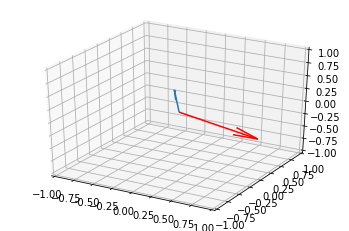

Validation loss:  0.19073363925729478


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 2 		 Training Loss: 0.17420742583685908


100%|██████████| 58/58 [00:41<00:00,  1.38it/s]


Epoch 3 		 Training Loss: 0.14949663985392142


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 4 		 Training Loss: 0.14225059465087694


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 5 		 Training Loss: 0.1373851046223065


100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch 6 		 Training Loss: 0.13258199753432437


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 7 		 Training Loss: 0.12825661114063755


100%|██████████| 58/58 [00:41<00:00,  1.38it/s]


Epoch 8 		 Training Loss: 0.1253544618857318


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 9 		 Training Loss: 0.12309174111177182


100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch 10 		 Training Loss: 0.12014168064142096


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 11 		 Training Loss: 0.11745783365492163


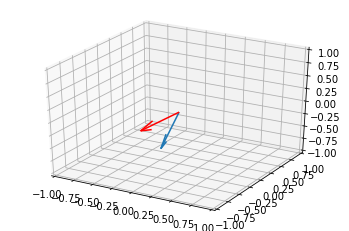

Validation loss:  0.11625698953866959


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 12 		 Training Loss: 0.11525533489626029


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 13 		 Training Loss: 0.11284571102467077


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 14 		 Training Loss: 0.11074250229987605


100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch 15 		 Training Loss: 0.10793461290926769


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 16 		 Training Loss: 0.10404809011981406


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 17 		 Training Loss: 0.10270378700104253


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 18 		 Training Loss: 0.09870323885617585


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 19 		 Training Loss: 0.09854066924288354


100%|██████████| 58/58 [00:41<00:00,  1.38it/s]


Epoch 20 		 Training Loss: 0.09531417771660049


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 21 		 Training Loss: 0.0942506973856482


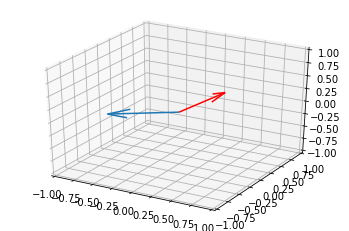

Validation loss:  0.09710677180971418


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 22 		 Training Loss: 0.09247275210660079


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 23 		 Training Loss: 0.09107307087758491


100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch 24 		 Training Loss: 0.09115651673797903


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 25 		 Training Loss: 0.08931456146569088


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 26 		 Training Loss: 0.08972652564788687


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 27 		 Training Loss: 0.08815459534525871


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 28 		 Training Loss: 0.08717178656109448


100%|██████████| 58/58 [00:41<00:00,  1.38it/s]


Epoch 29 		 Training Loss: 0.0872650620495451


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 30 		 Training Loss: 0.08609981526588571


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 31 		 Training Loss: 0.08524245486177247


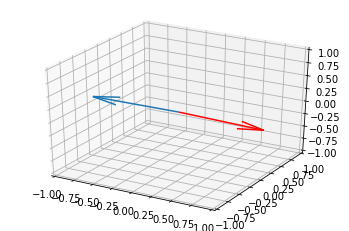

Validation loss:  0.08708526087658745


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 32 		 Training Loss: 0.08541143043287869


100%|██████████| 58/58 [00:41<00:00,  1.38it/s]


Epoch 33 		 Training Loss: 0.08418023419277422


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 34 		 Training Loss: 0.08337897601826437


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 35 		 Training Loss: 0.08293179075779586


100%|██████████| 58/58 [00:41<00:00,  1.38it/s]


Epoch 36 		 Training Loss: 0.08199219919484237


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 37 		 Training Loss: 0.08135024137024222


100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch 38 		 Training Loss: 0.08076489716768265


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 39 		 Training Loss: 0.07902720082422783


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 40 		 Training Loss: 0.07805157966654876


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 41 		 Training Loss: 0.07764530104809794


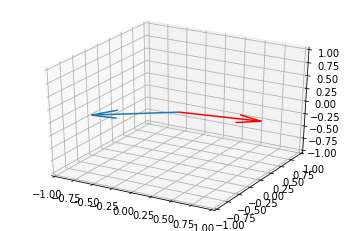

Validation loss:  0.07957551521914345


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 42 		 Training Loss: 0.07642974588891556


100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch 43 		 Training Loss: 0.07559882952221508


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 44 		 Training Loss: 0.0746928755322407


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 45 		 Training Loss: 0.07569589041944208


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 46 		 Training Loss: 0.07292449011884887


100%|██████████| 58/58 [00:41<00:00,  1.38it/s]


Epoch 47 		 Training Loss: 0.07214090896063838


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 48 		 Training Loss: 0.07220899943133881


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 49 		 Training Loss: 0.07040518817716632


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 50 		 Training Loss: 0.06837587386112788


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 51 		 Training Loss: 0.06903397388242442


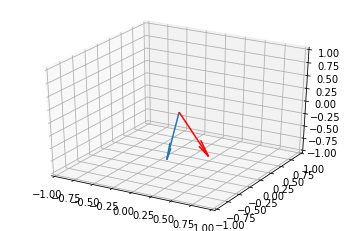

Validation loss:  0.06772673449345998


100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch 52 		 Training Loss: 0.06832998663443944


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 53 		 Training Loss: 0.06457985674255881


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 54 		 Training Loss: 0.0637888931508722


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 55 		 Training Loss: 0.0636063040202034


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 56 		 Training Loss: 0.06186136654738722


100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch 57 		 Training Loss: 0.05891523869900868


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 58 		 Training Loss: 0.05899523352754527


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 59 		 Training Loss: 0.05760809856242147


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 60 		 Training Loss: 0.056454536087554075


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 61 		 Training Loss: 0.056112910203378774


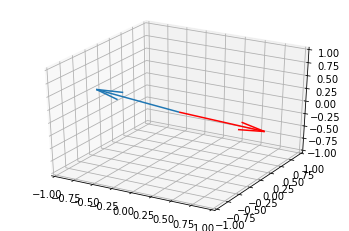

Validation loss:  0.05447328143886158


100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch 62 		 Training Loss: 0.05624603717748461


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 63 		 Training Loss: 0.054088008301011445


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 64 		 Training Loss: 0.05387706033371646


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 65 		 Training Loss: 0.0529769889624982


100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch 66 		 Training Loss: 0.05263034992947661


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 67 		 Training Loss: 0.05186505300988411


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 68 		 Training Loss: 0.05289501144454397


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 69 		 Training Loss: 0.05180131367825229


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 70 		 Training Loss: 0.050037513840301286


100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch 71 		 Training Loss: 0.05012901178721724


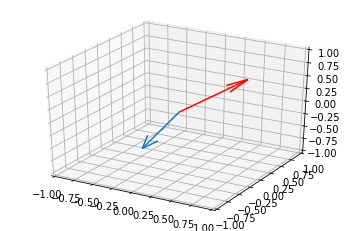

Validation loss:  0.058656474841492515


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 72 		 Training Loss: 0.0518679973380319


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 73 		 Training Loss: 0.050981103924327885


100%|██████████| 58/58 [00:41<00:00,  1.38it/s]


Epoch 74 		 Training Loss: 0.04848774561080439


  7%|▋         | 4/58 [00:03<00:49,  1.10it/s]


KeyboardInterrupt: ignored

In [ ]:
net = Net_2()
net.train()
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
#criterion = nn.MSELoss()
epochs = 100
eval_every = 10

train_losslist = []
val_losslist = []
for e in range(epochs):
    train_loss = 0.0
    net.train()
    for Data in tqdm(trainloader):
        #Training 
        x_train,y_train = Data
        y_train = y_train.cuda()
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        batch_size,_,_,_ = x_train.shape
        y_pred = net(x_train.reshape([batch_size,1,height,width,depth]))
        # Find the Loss
        loss = MSENorm(y_train,y_pred)
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
        train_losslist.append(loss.item())
        #print(train_loss)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)}')
    if e % eval_every == 0:
      validation_loss = 0
      net.eval()
      for j, Data in enumerate(valloader):
                x_val,y_val = Data
                y_val = y_val.cuda()
                batch_size,_,_,_ = x_val.shape
                yval_pred = net(x_val.reshape([batch_size,1,height,width,depth]))
                v_loss= MSENorm(y_val, yval_pred).item()
                validation_loss += v_loss
                val_losslist.append(v_loss)
                if j == len(valloader)-1: # last validation batch:
                    fig = plt.figure()
                    ax = fig.add_subplot(111, projection='3d')
                    xr = random.randint(10,40)
                    yr = random.randint(10,40)
                    zr = random.randint(10,40)
                    ax.quiver(0,0,0,yval_pred[0,0,xr,yr,zr].item(),yval_pred[0,1,xr,yr,zr].item(),yval_pred[0,2,xr,yr,zr].item(),color = 'r')
                    ax.quiver(0,0,0,y_val[0,0,xr,yr,zr].item(),y_val[0,1,xr,yr,zr].item(),y_val[0,2,xr,yr,zr].item())
                    ax.set_xlim([-1, 1])
                    ax.set_ylim([-1, 1])
                    ax.set_zlim([-1, 1])
                    plt.show()
                    
                    print("Validation loss: ",validation_loss / len(valloader))

# Precalculated Structure Tensors# 

1.   List item
2.   List item



In [ ]:
torch.save(net.state_dict(), 'CarthTRAINED.pt')

0.18 epoch 80

